In [198]:
import spuco.datasets as dsets
from spuco.datasets.base_spuco_dataset import SpuriousFeatureDifficulty
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

Download modified MNIST data

In [186]:
trainset = dsets.spuco_mnist.SpuCoMNIST(
    root="data/mnist/",
    spurious_feature_difficulty=SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
    spurious_correlation_strength=0.995,
    classes=[[0,1],[2,3],[4,5],[6,7],[8,9]]
)
trainset.initialize()

testset = dsets.spuco_mnist.SpuCoMNIST(
    root="data/mnist/",
    spurious_feature_difficulty=SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
    spurious_correlation_strength=0.995,
    classes=[[0,1],[2,3],[4,5],[6,7],[8,9]],
    split='test'
)
testset.initialize()

100%|██████████| 10000/10000 [00:00<00:00, 49186.43it/s]


Check the data to see how it looks

2


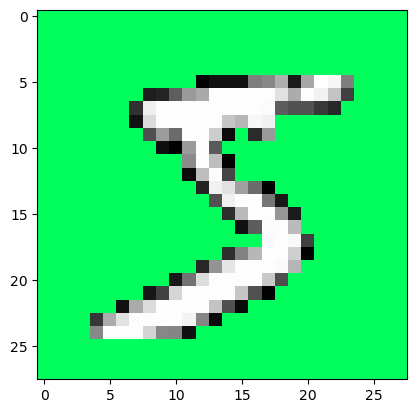

In [187]:
print(trainset[0][1])
array = np.transpose(np.array(trainset[0][0]), (1,2,0))
plt.imshow(array)

Define the architecture for the model we will be using.
First we use 2 convolution layers of size 5x5 and create 18 total images. We use a 2x2 window to maxpool the image and the activation function is Relu. Then we flatten the image and run it through a fully connected network of 288->64->5 neurons

In [188]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            nn.Conv2d(3,9,(5,5)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(9,18,(5,5)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Flatten(1,-1),
            nn.Linear(288,64),
            )
        self.relu = nn.ReLU()
        self.l = nn.Linear(64,5)

    def forward(self, x):
        x = self.net(x)
        x = self.relu(x)
        return self.l(x)
    

Data processing.
Training Batch size is 5.

In [189]:

scaler = StandardScaler()
batch_size = 5
train_labels = trainset.labels
train_images = np.array([trainset[i][0] for i in range(len(trainset))])
test_labels = testset.labels
test_images = np.array([testset[i][0] for i in range(len(testset))])
train_images = torch.tensor(train_images, dtype = torch.float32)
train_labels = torch.tensor(train_labels, dtype = torch.long)
test_images = torch.tensor(test_images, dtype = torch.float32)
test_labels = torch.tensor(test_labels, dtype = torch.long)
train1 = TensorDataset(train_images, train_labels)
test1 = TensorDataset(test_images, test_labels)
train = DataLoader(train1, batch_size)
test = DataLoader(test1,5)

Training with AdamW optimizer and learning rate of 0.00005. The loss function is Cross Entropy Loss. We train for 30 epochs. We also incorporate a transform to normalize the data and aid the training process, and use a learning rate reducer to help with plateaus in the training

In [194]:
model = LeNet()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = torch.nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
train_loss = []
test_loss = []
transform = T.Compose([
    T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])
epochs = 30
best_loss = 100000
for epoch in range(epochs):
    model.train()
    tot_loss = 0
    for x,y in train:
        x = transform(x)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        tot_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(tot_loss/len(train))

    tot_loss = 0
    model.eval()
    with torch.no_grad():
        for x,y in test:
            x = transform(x)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            tot_loss += loss.item()
        test_loss.append(tot_loss/len(test))
    if best_loss > test_loss[-1]:
        best_loss = test_loss[-1]
        torch.save(model.state_dict(), 'model.pt')
    print(f"Epoch {epoch+1}: Training Loss = {train_loss[epoch]:.4f}, Testing Loss = {test_loss[epoch]:.4f}")

Epoch 1: Training Loss = 0.0943, Testing Loss = 5.5661
Epoch 2: Training Loss = 0.0398, Testing Loss = 5.3547
Epoch 3: Training Loss = 0.0384, Testing Loss = 5.1971
Epoch 4: Training Loss = 0.0371, Testing Loss = 5.0019
Epoch 5: Training Loss = 0.0356, Testing Loss = 4.7599
Epoch 6: Training Loss = 0.0336, Testing Loss = 4.4667
Epoch 7: Training Loss = 0.0312, Testing Loss = 4.1415
Epoch 8: Training Loss = 0.0286, Testing Loss = 3.8335
Epoch 9: Training Loss = 0.0262, Testing Loss = 3.5498
Epoch 10: Training Loss = 0.0238, Testing Loss = 3.2978
Epoch 11: Training Loss = 0.0217, Testing Loss = 3.0694
Epoch 12: Training Loss = 0.0199, Testing Loss = 2.8742
Epoch 13: Training Loss = 0.0182, Testing Loss = 2.6892
Epoch 14: Training Loss = 0.0166, Testing Loss = 2.5236
Epoch 15: Training Loss = 0.0152, Testing Loss = 2.3963
Epoch 16: Training Loss = 0.0138, Testing Loss = 2.2892
Epoch 17: Training Loss = 0.0125, Testing Loss = 2.2013
Epoch 18: Training Loss = 0.0114, Testing Loss = 2.1334
E

Visulize loss over each epoch

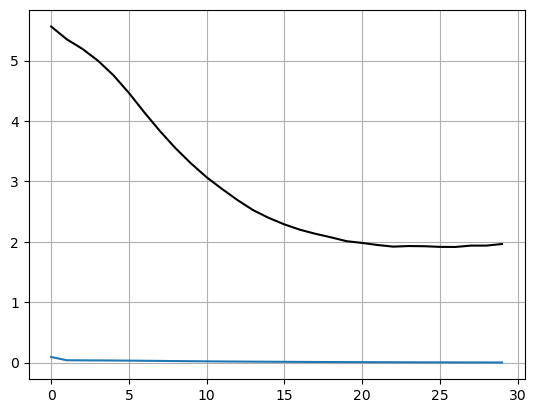

In [195]:
plt.plot(train_loss)
plt.plot(test_loss, color='black')
plt.grid(True)

Test the accuracy of the model after training

In [196]:
model.load_state_dict(torch.load('model.pt', weights_only=True))
num_correct = 0
model.eval()
with torch.no_grad():
    for x,y in test:
        y_pred = model(transform(x))
        num_correct += (torch.argmax(y_pred, dim=1) == y).sum().item()
print(f"{100*num_correct/(len(test) * 5)}% accuracy on test dataset")

        

57.96% accuracy on test dataset


Save the processed data into files for later use

In [197]:
torch.save(train_images,'/Users/sanjay/Desktop/Python Projects/AI/George/train_images.pt')
torch.save(train_labels, '/Users/sanjay/Desktop/Python Projects/AI/George/train_labels.pt')
torch.save(test_images, '/Users/sanjay/Desktop/Python Projects/AI/George/test_images.pt')
torch.save(test_labels, '/Users/sanjay/Desktop/Python Projects/AI/George/test_labels.pt')